<a href="https://colab.research.google.com/github/luchia0602/aligning-texts/blob/main/%D0%9F%D0%A0%D0%9E%D0%95%D0%9A%D0%A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install razdel # для разделения по предложениям
!pip3 install sentence-transformers # моделька с эмбеддингами
# библиотека для создания векторных представлений (эмбеддингов) предложений.
# основана на предобученных моделях, способных преобразовывать тексты
# в векторы, сохраняя семантическую информацию.
!pip install py-hasami # для японского, понадобится в другой вкладке

In [ ]:
import re # для предварительной обработки текстов
import seaborn as sns # для построения графика, основана на matplotlib
import numpy as np # для работы с массивами, матрицами

from scipy import spatial # для подсчёта косинусного рассстояния
from matplotlib import pyplot as plt # тоже для графика

import razdel # для разделения по предложениям
from sentence_transformers import SentenceTransformer # моделька

In [ ]:
#@title Japanese text
#import hasami
#with open('HP JAP.txt', 'r', encoding='utf-8') as file:
#  jp_text = file.read()
#  jp = re.sub('\n', ' ', jp_text)
#  sent_jp = hasami.segment_sentences(jp)
#  print("Japanese text:", len(sent_jp), "sentences")
#  print(sent_jp[0])

In [ ]:
#@title with RE
#double_dash = re.compile(r'[--]+')
#quotes_de = re.compile(r'[»«]+')

#ru = re.sub('\n', ' ', 'text_ru.txt')
#ru = re.sub(double_dash, '—', ru)

#de = re.sub('\n', ' ', 'text_de.txt')
#de = re.sub(quotes_de, ' ', de)

#sent_ru = list(x.text for x in razdel.sentenize(ru))
#sent_de = list(x.text for x in razdel.sentenize(de))

In [ ]:
with open('HP_eng_9.txt', 'r', encoding='utf-8') as file:
  en_text = file.read()
  en = re.sub('\n', ' ', en_text) # заменяем переносы строк на обычные пробелы, чтобы предложения считались нормально
  sent_en = list(x.text for x in razdel.sentenize(en)) # получаем список предложений. x.text нужен для отображения именно ТЕКСТОВОГО содержимого
  print("English text:", len(sent_en), "sentences")
  print(sent_en[0])

Harry had never believed he would meet a boy he hated more than Dudley, but that was before he met Draco Malfoy.


In [ ]:
#sent_en[:10]

In [ ]:
with open('HP_rus_9.txt', 'r', encoding='utf-8') as file: # то же самое для русского текста
  ru_text = file.read()
  ru = re.sub('\n', ' ', ru_text)
  sent_ru = list(x.text for x in razdel.sentenize(ru))
  print("Russian text:", len(sent_ru), "sentences")
  print(sent_ru[0])

Russian text: 490 sentences
До приезда в Хогвартс Гарри и не представлял, что может ненавидеть кого-нибудь сильнее, чем Дадли.


In [ ]:
#sent_ru[:10]

batching: техника, чтобы собирать и обрабатывать элементы (вектора) одновременно, а не по отдельности. просто для оптимизации процесса

In [ ]:
def get_batch(iter1, iter2, batch_size): # batch_size: 388 предложений (по английскому)
    l1 = len(iter1) # здесь будут все предложения на русском
    l2 = len(iter2) # а здесь - на английском
    k = int(round(batch_size * l2/l1)) # коэффицент для подсчёта разницы в кол-ве предложений (102), k=307
    kdx = 0 - k # для отслеживания текущего коэффицента при формировании батчей
    for ndx in range(0, l1, batch_size): # от 0 до 388 с шагом 388
        kdx += k # при каждом повторе добавляется коэффицент
        yield iter1[ndx:min(ndx + batch_size, l1)], iter2[kdx:min(kdx + k, l2)]
        # создаётся генератор данных из двух текстов; 388 элементов из первого и +k из второго, так как рус. текст значительно длиннее.
        # в итоге считаем разницу между ними и собираем данные
        # min для того, чтобы не вылезало за пределы текстов
        # yeild - как return, но сохраняется состояние, к нему можно вернуться потом

loading pretrained model

In [ ]:
model_st = SentenceTransformer('distiluse-base-multilingual-cased') # загружаем модельку (японский не входит в список, но пишут, что будет работать)
#model_st = SentenceTransformer('xlm-r-100langs-bert-base-nli-mean-tokens')

parameters

In [ ]:
batch_number = 0
total_pairs = 0
batch_size = 388 # смотрим весь текст
window = 10 # ширина окна для определения сходства, в любую сторону десять предложений
threshold = 0.3 # минимальный порог схожести

In [ ]:
def get_sim_matrix(vec1, vec2, window=10): # для создании матрицы сходства между векторами
    sim_matrix=np.zeros((len(vec1), len(vec2))) # метод numpy, создаём матрицу размером с длины корпусов со всеми нулевыми значениями, чтобы потом заполнить
    k = len(vec1)/len(vec2) # разница длины между векторами
    for i in range(len(vec1)): # итерация по всем парам векторов, вычисление кос. сходства между векторами в окне
        for j in range(len(vec2)):
            if (j*k > i-window) and (j*k < i+window): # считаем конусное сходство. косинусное расстояние между векторами (1 = идентичны)
              sim = 1 - spatial.distance.cosine(vec1[i], vec2[j])
              # spatial... - функция из библиотеки SciPy, вычисляет конус между двумя векторами. из этого и получаем степень похожести
              sim_matrix[i,j] = sim
    return sim_matrix
# window = это какое-то кол-во предложений вперёд/назад от оси выравнивания (главная диагональ матрицы, которая должна быть в идеале), здесь 10
# находится ли j в пределах окна относительно индекса i, при условии, что индексы соотносятся между векторами через к
# нужно для выравнивания индексов, чтобы учесть различия в масштабах длин векторов + сравнение только в пределах окна

In [ ]:
vectors1, vectors2 = [], []
# оптимизированные данные загружаем в модельку и получаем вектора предложений
for lines_ru_batch, lines_en_batch in get_batch(sent_ru, sent_en, batch_size):
    batch_number += 1
    vectors1 = [*vectors1, *model_st.encode(lines_en_batch)] # model_st.encode() - метод для кодирования текста. то есть получаем векторы для всех предложений
    vectors2 = [*vectors2, *model_st.encode(lines_ru_batch)]

    break

In [ ]:
len(vectors1[0]) # так и должно быть, длина эмбеддинга в этой модельке 512 (а может быть 768 в других модельках)

512

In [ ]:
len(vectors2[0])

512

In [ ]:
sim_matrix = get_sim_matrix(vectors1, vectors2, window)
# функция sim_matrix вычисляет матрицу сходства между векторами, используя окно (то есть 10 предложений в любую сторону)
# в итоге имеем sim_matrix(i,j), где i - предложение на рус, j - предложение на англ, итого их степень сходства

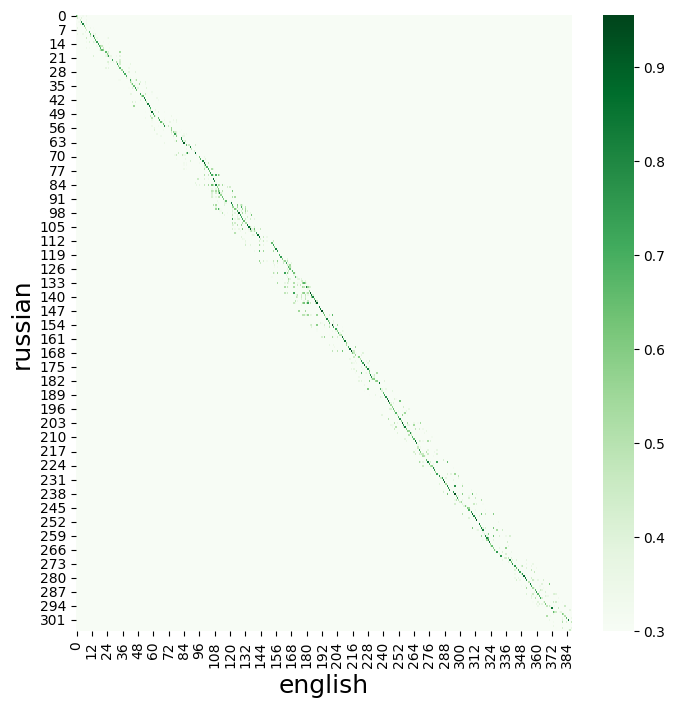

In [ ]:
plt.figure(figsize=(8,8)) # размер таблицы
sns.heatmap(sim_matrix, cmap="Greens", vmin=threshold) # пары схожестью меньше 0.3 не интересуют. создаём тепловую карту (чем выше значение, тем ярче цвет)
plt.xlabel("english", fontsize=18)
plt.ylabel("russian", fontsize=18)
plt.show()

Ищем идеальные совпадения, смотрим на новую схему

In [ ]:
sim_matrix_best = np.zeros_like(sim_matrix) # такая же матрица, но заполненная нулями
sim_matrix_best[range(len(sim_matrix)), sim_matrix.argmax(1)] = sim_matrix[range(len(sim_matrix)), sim_matrix.argmax(1)]
# argmax(1) - для каждой строки в матрице находит индекс максимального значения, возвращает массив таких максимальных значений
# в промежутке от 1 до длины матрицы присваивает максимальные значения
# в итоге получаем новую матрицу, содержащую только максимальные значения из изначальной матрицы, без выбросов

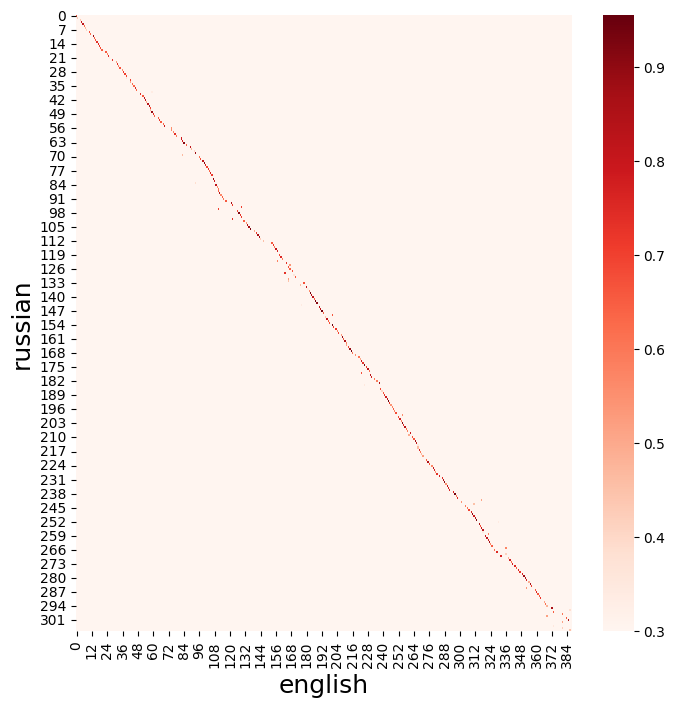

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(sim_matrix_best, cmap="Reds", vmin=threshold)
plt.xlabel("english", fontsize=18)
plt.ylabel("russian", fontsize=18)
plt.show()

In [ ]:
# извлекаем пары предложений и соответствующих значений из матрицы, основываясь на пороговом значении
def get_pairs(ru_lines, en_lines, sim_matrix, threshold):
    ru = []
    en = []
    sims = []
    for i in range(sim_matrix.shape[0]): # sim_matrix_shape[0] - строки (англ)
        for j in range(sim_matrix.shape[1]): # sim_matrix_shape[1] - столбцы (рус)
            if sim_matrix[i,j] >= threshold: # если схожесть выше порога (0.3, например)
                ru.append(ru_lines[j])
                en.append(en_lines[i])
                sims.append(sim_matrix[i,j])
    return ru, en, sims # получаем лучшие сходства рус, англ. это архив

In [ ]:
res_ru, res_en, sims = get_pairs(sent_ru, sent_en, sim_matrix, threshold)

In [ ]:
len(res_ru)

1203

In [ ]:
for x, y, s in zip(res_ru, res_en, sims):
    print(x)
    print(y)
    print("")
    print(">> similarity", s, "\n\n")

In [ ]:
sim_matrix_best = np.zeros_like(sim_matrix)
sim_matrix_best[range(len(sim_matrix)), sim_matrix.argmax(1)] = sim_matrix[range(len(sim_matrix)), sim_matrix.argmax(1)]

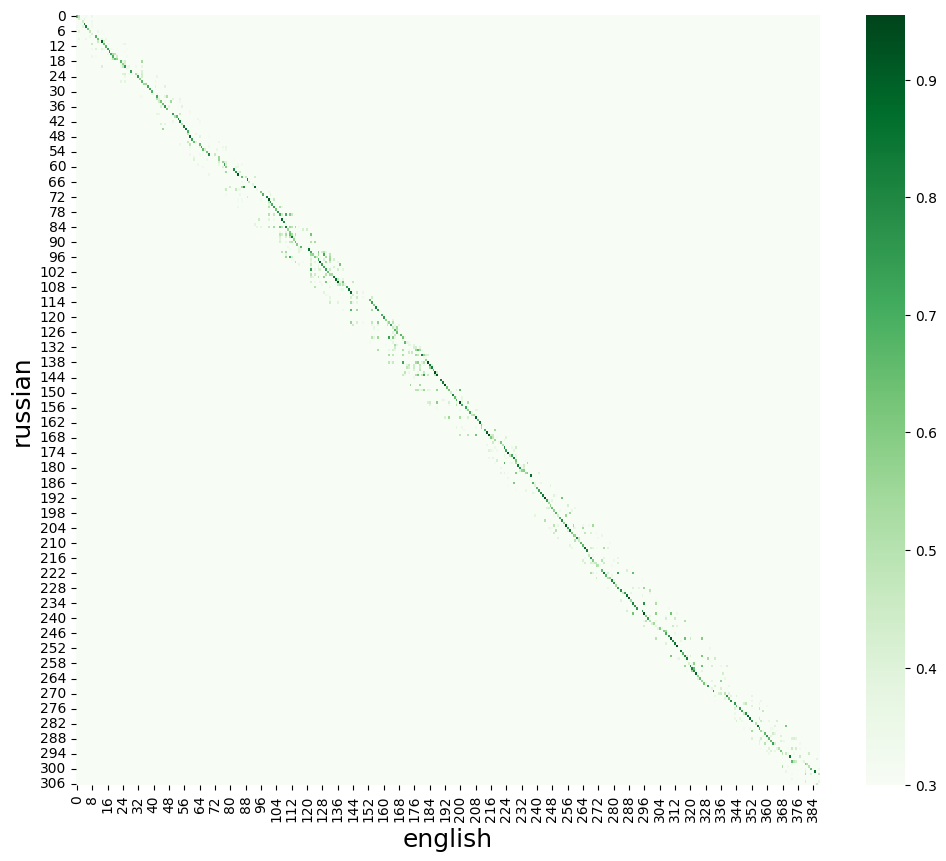

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(sim_matrix_best, cmap="Greens", vmin=threshold)
plt.xlabel("english", fontsize=18)
plt.ylabel("russian", fontsize=18)
plt.show()

In [ ]:
res_ru, res_en, sims = get_pairs(sent_ru, sent_en, sim_matrix_best, threshold)

In [ ]:
print(len(res_en))
print(len(res_ru))

301
301


In [ ]:
for x, y, s in zip(res_en, res_ru, sims):
    print(x)
    print(y)
    print("")
    print(">> similarity", s, "\n\n")

In [ ]:
import pandas as pd
data = pd.DataFrame({'ru': res_ru, 'en': res_en, 'sim': sims})
data

,ru,en,sim
0,"До приезда в Хогвартс Гарри и не представлял, ...",Harry had never believed he would meet a boy h...,0.653130
1,"Но это было до того, как он встретил Драко Мал...","Still, first-year Gryffindors only had Potions...",0.432518
2,"Однако, вернувшись от Хагрида, Гарри и Рон зам...","Or at least, they didn’t until they spotted a ...",0.433398
3,Со вторника начинались полеты на метлах — и пе...,Flying lessons would be starting on Thursday —...,0.805359
4,"— Великолепно, — мрачно заметил Гарри.","“Typical,” said Harry darkly.",0.824407
...,...,...,...
296,"— Нам надо вернуться в башню Гриффиндора, — пр...","“We’ve got to get back to Gryffindor Tower,” s...",0.863805
297,"— Думаю, мы оторвались, — с трудом выговорил Г...","“Malfoy tricked you,” Hermione said to Harry.",0.513710
298,"— БЕЖИМ! — истошно завопил Гарри, и все четвер...",He was never going to meet you — Filch knew so...,0.350908
299,"— Думаю, мы оторвались, — с трудом выговорил Г...","Harry thought she was probably right, but he w...",0.420650


In [ ]:
data.to_excel('HP_corpora.xlsx') # загружаем pandas в имеющийся файл excel, получаем файл excel

In [ ]:
data_eng_rus = pd.read_excel ('HP_corpora_complete.xlsx') # загружаем файл excel русский+английский

In [ ]:
data_eng_jap = pd.read_excel ('ENG_JAP_corpora_complete.xlsx') # читаем таблицу с английский+японский

In [ ]:
data_eng_rus # смотрим, проверяем

,Unnamed: 0,ru,en,sim
0,0,"До приезда в Хогвартс Гарри и не представлял, ...",Harry had never believed he would meet a boy h...,0.653130
1,1,"Но это было до того, как он встретил Драко Мал...","Still, first-year Gryffindors only had Potions...",0.432518
2,2,"Однако, вернувшись от Хагрида, Гарри и Рон зам...","Or at least, they didn’t until they spotted a ...",0.433398
3,3,Со вторника начинались полеты на метлах — и пе...,Flying lessons would be starting on Thursday —...,0.805359
4,4,"— Великолепно, — мрачно заметил Гарри.","“Typical,” said Harry darkly.",0.824407
...,...,...,...,...
378,378,"Забравшись в постель, Гарри думал не о том, он...",But Hermione had given Harry something else to...,0.690137
379,379,"О том, что пес что-то охраняет.",The dog was guarding something. . . .,0.766955
380,380,"Забравшись в постель, Гарри думал не о том, он...",What had Hagrid said?,0.440453
381,381,Он вспомнил слова Хагрида: «Если хочешь что-ни...,Gringotts was the safest place in the world fo...,0.699595


In [ ]:
data_eng_jap # всё на месте

,Unnamed: 0,ja,en,sim
0,0,ダドリーより嫌なヤツがこの世の中にいるなんて、ハリーは思ってもみなかった。,Harry had never believed he would meet a boy h...,0.661952
1,1,一年生ではグリフィンドールとスリザリンが一緒のクラスになるのは魔法薬学の授業だけだったので、...,"Still, first-year Gryffindors only had Potions...",0.502783
2,2,少なくとも、グリフィンドールの談話室に「お知らせ」が出るまではそうだった。,"Or at least, they didn’t until they spotted a ...",0.512457
3,3,――飛行訓練は木曜日に始まります。,Flying lessons would be starting on Thursday —...,0.599966
4,4,ダドリーより嫌なヤツがこの世の中にいるなんて、ハリーは思ってもみなかった。,"“Typical,” said Harry darkly.",0.396301
...,...,...,...,...
264,264,ベッドに入ってからそれを考えていた。,But Hermione had given Harry something else to...,0.417430
265,265,犬が何かを守っている……ハグリッドが何て言ったっけ？,The dog was guarding something. . . .,0.590029
266,266,犬が何かを守っている……ハグリッドが何て言ったっけ？,What had Hagrid said?,0.516516
267,267,「グリンゴッツは何かを隠すには世界で一番安全な場所だ――たぶんホグワーツ以外では……」 七一...,Gringotts was the safest place in the world fo...,0.669144


In [ ]:
result = data_eng_rus.merge(data_eng_jap, on="en", how="outer") # how = параметр объединения. здесь мы объединяем по ключу, все уникальные значения столбика с англ сохранятся, а отсутствующие заполнятся NaN

In [ ]:
del result['Unnamed: 0_x'] # это номера столбцов, оставшиеся после excel. не нужны
del result['Unnamed: 0_y']

In [ ]:
result # ура, таблица сразу по трём языкам + схожести! но много NaN, то есть не получившихся пар

,ru,en,sim_x,ja,sim_y
0,"До приезда в Хогвартс Гарри и не представлял, ...",Harry had never believed he would meet a boy h...,0.653130,ダドリーより嫌なヤツがこの世の中にいるなんて、ハリーは思ってもみなかった。,0.661952
1,"Но это было до того, как он встретил Драко Мал...","Still, first-year Gryffindors only had Potions...",0.432518,一年生ではグリフィンドールとスリザリンが一緒のクラスになるのは魔法薬学の授業だけだったので、...,0.502783
2,"Однако, вернувшись от Хагрида, Гарри и Рон зам...","Or at least, they didn’t until they spotted a ...",0.433398,少なくとも、グリフィンドールの談話室に「お知らせ」が出るまではそうだった。,0.512457
3,Со вторника начинались полеты на метлах — и пе...,Flying lessons would be starting on Thursday —...,0.805359,――飛行訓練は木曜日に始まります。,0.599966
4,"— Великолепно, — мрачно заметил Гарри.","“Typical,” said Harry darkly.",0.824407,ダドリーより嫌なヤツがこの世の中にいるなんて、ハリーは思ってもみなかった。,0.396301
...,...,...,...,...,...
378,"Забравшись в постель, Гарри думал не о том, он...",But Hermione had given Harry something else to...,0.690137,ベッドに入ってからそれを考えていた。,0.417430
379,"О том, что пес что-то охраняет.",The dog was guarding something. . . .,0.766955,犬が何かを守っている……ハグリッドが何て言ったっけ？,0.590029
380,"Забравшись в постель, Гарри думал не о том, он...",What had Hagrid said?,0.440453,犬が何かを守っている……ハグリッドが何て言ったっけ？,0.516516
381,Он вспомнил слова Хагрида: «Если хочешь что-ни...,Gringotts was the safest place in the world fo...,0.699595,「グリンゴッツは何かを隠すには世界で一番安全な場所だ――たぶんホグワーツ以外では……」 七一...,0.669144


In [ ]:
result.to_excel('result.xlsx')